In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import math
from google.colab import drive

# 1. Kết nối Drive
drive.mount('/content/drive')

# 2. Cấu hình đường dẫn
BASE_DIR = "/content/drive/My Drive/IE403"
INPUT_DIR = os.path.join(BASE_DIR, "data/transformer_input")
MODEL_SAVE_DIR = os.path.join(BASE_DIR, "models_sota")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# 3. Tối ưu hóa cho A100
# Bật TensorFloat-32 (TF32) trên A100 để tăng tốc độ tính toán ma trận
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Hardware: {torch.cuda.get_device_name(0)}")
print(f"🚀 TF32 Enabled: {torch.backends.cuda.matmul.allow_tf32}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Hardware: NVIDIA A100-SXM4-80GB
🚀 TF32 Enabled: True


In [ ]:
# --- CUSTOM LOSS FUNCTION ---
class DirectionalLoss(nn.Module):
    def __init__(self, alpha=5.0):
        """
        alpha: Trọng số phạt sai hướng.
        Alpha càng lớn, model càng sợ đoán sai hướng.
        """
        super(DirectionalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, pred, target):
        # 1. Lỗi độ lớn (Magnitude Error)
        loss_mse = self.mse(pred, target)

        # 2. Lỗi xu hướng (Direction Error)
        # Sử dụng Tanh để xấp xỉ hàm Sign (để có đạo hàm train được)
        # Nếu pred và target cùng dấu -> tích > 0 -> loss nhỏ
        # Nếu trái dấu -> tích < 0 -> loss lớn
        soft_sign_pred = torch.tanh(pred * 10) # *10 để làm dốc hàm tanh
        soft_sign_target = torch.tanh(target * 10)

        # Loss hướng = 1 - cosine_similarity (hoặc tích)
        # Ở đây dùng tích đơn giản: Nếu trái dấu thì phạt
        dir_penalty = torch.mean(torch.relu(1.0 - soft_sign_pred * soft_sign_target))

        return loss_mse + (self.alpha * dir_penalty)

# --- DATASET ---
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = torch.FloatTensor(data)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, index):
        x = self.data[index : index + self.seq_len]
        y = self.data[index + self.seq_len, 0] # Cột 0 là Returns
        return x, y

def load_data_returns(file_path, seq_len=30):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    # Target: Return ngày mai
    df['target'] = df['close'].pct_change().shift(-1)

    # Feature Engineering nhẹ
    if 'volume' in df.columns:
        df['volume'] = np.log1p(df['volume'])

    df = df.dropna()

    # Đưa target lên đầu
    cols = ['target'] + [c for c in df.columns if c != 'target']
    df = df[cols]

    # Split
    n = len(df)
    train_end = int(n * 0.8) # Tăng tập train lên 80% để học kỹ hơn

    # Scaler
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df.iloc[:train_end])
    test_scaled = scaler.transform(df.iloc[train_end:])

    # Lưu gốc để vẽ
    test_df_origin = df.iloc[train_end:].copy()

    return train_scaled, test_scaled, scaler, df.shape[1], test_df_origin

In [ ]:
class SotaStockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=6, dropout=0.2, seq_len=30):
        super(SotaStockTransformer, self).__init__()

        self.feature_embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.final_norm = nn.LayerNorm(d_model)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, src):
        x = self.feature_embedding(src)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)

        x = self.transformer_encoder(x)

        # Global Average Pooling (Thay vì chỉ lấy last step)
        # Giúp model nhìn tổng thể cả cửa sổ 30 ngày
        x = x.mean(dim=1)

        x = self.final_norm(x)
        output = self.decoder(x)
        return output

In [ ]:
def train_and_eval(ticker, df_path, config):
    print(f"\n⚡ TRAINING: {ticker} (Directional Loss)")

    if not os.path.exists(df_path):
        print(f"❌ File not found: {df_path}")
        return

    train_data, test_data, scaler, input_dim, test_origin = load_data_returns(df_path, config['seq_len'])

    train_loader = DataLoader(StockDataset(train_data, config['seq_len']), batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(StockDataset(test_data, config['seq_len']), batch_size=config['batch_size'], shuffle=False)

    model = SotaStockTransformer(input_dim, config['d_model'], config['nhead'], config['num_layers'], config['dropout'], config['seq_len']).to(device)

    # SỬ DỤNG DIRECTIONAL LOSS
    criterion = DirectionalLoss(alpha=10.0).to(device) # alpha=10 phạt sai hướng rất nặng

    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
    scaler_amp = torch.cuda.amp.GradScaler()

    # Training
    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output = model(x)
                loss = criterion(output.squeeze(), y)

            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler_amp.step(optimizer)
            scaler_amp.update()
            train_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['epochs']} | Loss: {train_loss/len(train_loader):.5f}")

    # Testing
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x).cpu().numpy()
            preds.extend(out)
            # Lấy y gốc chưa qua loss (để tính metric)
            actuals.extend(y.cpu().numpy())

    # Inverse Scale
    dummy = np.zeros((len(preds), input_dim))
    dummy[:, 0] = np.array(preds).flatten()
    pred_returns = scaler.inverse_transform(dummy)[:, 0]

    # Tính Directional Accuracy
    # Lấy ground truth từ dataframe gốc để chính xác nhất
    true_returns = test_origin['target'].values[config['seq_len']:]
    # Cắt cho khớp độ dài (do batching có thể dư thiếu)
    min_len = min(len(pred_returns), len(true_returns))
    pred_returns = pred_returns[:min_len]
    true_returns = true_returns[:min_len]

    correct = 0
    for p, t in zip(pred_returns, true_returns):
        if (p > 0 and t > 0) or (p < 0 and t < 0):
            correct += 1

    acc = correct / len(pred_returns) * 100
    print(f"🎯 DIRECTIONAL ACCURACY: {acc:.2f}%")

    # Vẽ Biểu đồ One-step Ahead Reconstruction
    base_price = test_origin['close'].values[config['seq_len']-1]
    plot_actual = test_origin['close'].values[config['seq_len']:][:min_len]
    plot_pred = []

    prev_price = base_price
    for i in range(min_len):
        # Giá dự báo = Giá thực tế hôm qua * (1 + Return dự báo)
        # Đây là cách trader dùng model: Sáng ngủ dậy, chạy model, ra return -> chốt lệnh
        next_p = prev_price * (1 + pred_returns[i])
        plot_pred.append(next_p)
        prev_price = plot_actual[i] # Update giá thật để dự báo bước tiếp

    plt.figure(figsize=(12, 6))
    plt.plot(plot_actual, label='Thực tế', color='black', alpha=0.6)
    plt.plot(plot_pred, label='AI Dự báo (Đã phạt sai hướng)', color='red', linestyle='--')
    plt.title(f"{ticker}: Dự báo với Directional Loss (Acc: {acc:.2f}%)")
    plt.legend()
    plt.show()


⚡ TRAINING: FPT (Directional Loss)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-1467049763.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1467049763.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/250 | Loss: 10.44127
Epoch 20/250 | Loss: 10.62618
Epoch 30/250 | Loss: 10.37685
Epoch 40/250 | Loss: 10.43098
Epoch 50/250 | Loss: 10.03847
Epoch 60/250 | Loss: 10.07976
Epoch 70/250 | Loss: 10.03270
Epoch 80/250 | Loss: 10.13045
Epoch 90/250 | Loss: 9.86310
Epoch 100/250 | Loss: 9.58071
Epoch 110/250 | Loss: 9.72615
Epoch 120/250 | Loss: 9.74655
Epoch 130/250 | Loss: 9.44127
Epoch 140/250 | Loss: 9.15853
Epoch 150/250 | Loss: 9.36942
Epoch 160/250 | Loss: 9.02232
Epoch 170/250 | Loss: 9.35625
Epoch 180/250 | Loss: 8.99229
Epoch 190/250 | Loss: 8.94565
Epoch 200/250 | Loss: 9.07000
Epoch 210/250 | Loss: 8.65342
Epoch 220/250 | Loss: 8.71236
Epoch 230/250 | Loss: 8.46380
Epoch 240/250 | Loss: 8.11874
Epoch 250/250 | Loss: 8.15278
🎯 DIRECTIONAL ACCURACY: 57.41%


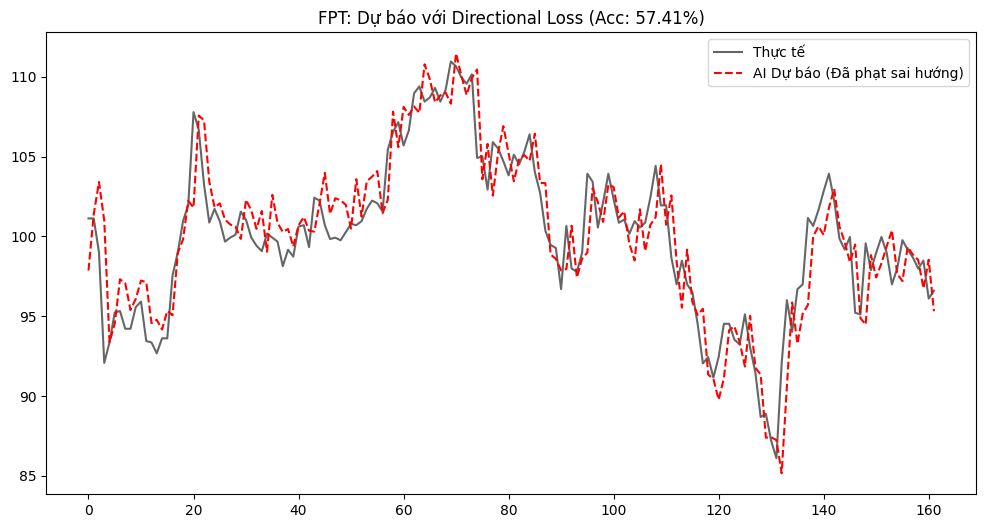

In [ ]:
CONFIG = {
    'seq_len': 30,
    'batch_size': 256,   # Tăng batch size
    'd_model': 256,
    'nhead': 8,
    'num_layers': 6,
    'dropout': 0.3,      # Tăng dropout để tránh học vẹt
    'lr': 5e-5,          # Giảm LR để học chậm mà chắc
    'epochs': 250
}

TARGET_TICKERS = ["VIC", "FPT", "BID", "VNM", "VJC"]

for ticker in TARGET_TICKERS:
    file_path = os.path.join(INPUT_DIR, f"{ticker}_final_dataset.csv")
    if os.path.exists(file_path):
        train_and_eval(ticker, file_path, CONFIG)